In [1]:
import bardensr
import matplotlib.pylab as plt
import numpy as np
import IPython.display
%matplotlib inline
%load_ext autoreload
%autoreload 2

```
Multiplexing (sometimes contracted to muxing) is a method 
by which multiple analog or digital signals are combined 
into one signal over a shared medium.

-- Wikipedia
```

The `BarDensr` (Barcode Demixing through non-negative spatial regression) package is a collection of tools for modeling linearly multiplexed observations.  There is some true signal we are interested in, but our observations are some noisy linear mixture of those signals.  

Specifically, we assume the following setup.

1. The samples.  There is a two- or three-dimensional object being examined.  In deference to the spatial transcriptomics applications, this object will hereafter be called the **"samples."**
2. The barcodes.  There are several different kinds of objects which manifest in the samples (e.g. different types of rolonies in a spatial transcriptomics experiment).  Hereafter, each kind of object will be referred to as a **"barcodes."**  We will let J denote the total number of different barcodes.
3. The voxels.  The tissue is measured on a two- or three- dimensional grid.  Hereafter, each measured location will be referred to as a **"voxel."**  We will let M denote the total number of voxels.
4. The barcode density.  For each voxel (`m`) and each barcode (`j`), we may imagine that there is a positive number indicating something like the density of that barcode within that voxel.   We will herafter refer to this as the **barcode density**.
5. The frames and imagestack.  The tissue is measured several times under different conditions (e.g. with different lasers, in different imaging rounds in the spatial transcriptomics experiment).  Hereafter, each condition will be referred to as a **"frame."**  Collectively, the measurements for all voxels under all conditions will be called the **"imagestack."**  We will let N denote the total number of frames.
6. The model.  Given the density, we assume the imagestack may be approximately modeled using the following observation model:
    1. First, apply a linear transformation to the density, independently for each barcodes.  This linear transformation will typically be something like a blur kernel. It will hereafter be referred to as the **"point-spread function"** and the result will be called the **"blurred density"**.
    2.  Second, apply a linear transformation to the blurred density, indepently for each voxel.  This linear transformation can be understood as an NxJ matrix, whcih will hereafter be referred to as the **"codebook"**. The product of this linear transformation will be called the **"noiseless imagestack"**.
    3.  Finally, add noise to the noiseless imagestack.

Put another way, slightly more concisely:
- There are J different "barcodes" (e.g. 300 different kinds of RNA transcripts)
- There is a grid of M0 x M1 x M2 "voxels" (e.g. 2048 x 2048 x 150 voxels)
- There are N different "frames" (e.g. 7 imaging rounds and 4 channels = 28 frames)
- There is an unobservable M0 x M1 x M2 x J "density" giving a nonnegative value for each barcode at each voxel
- There is a N x J "codebook" matrix full of nonnegative numbers, indicating how much we expect a given gene (`j`) to contribute to the observations at given frame (`n`).
- We observe a F x M0 x M1 x M2 "imagestack" giving a nonnegative value for each frame at each voxel
- Given the density, we assume the imagestack can be modelled by the following process: blur along the spatial dimensions, apply the codebook along the gene dimensions, and add noise.

# Staring at the data

To start with, let's look at an example of the kind of problem BarDensr is designed for.  The BarDensr package comes with a few benchmarks which can be used to examine performance.  Let's load one of them.

In [2]:
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')

Error: Jupyter cannot be started. Error attempting to locate jupyter: Data Science libraries jupyter and notebook are not installed in interpreter Python 3.8.2 64-bit.

This is a spatial transcriptomics benchmark.  It is from an experiment similar to [BARseq](https://www.sciencedirect.com/science/article/pii/S0092867419310748) with 7 imaging rounds and 4 channels.  For detailed information on this experiment, check out the [BarDensr paper](https://github.com/jacksonloper/bardensr/examples/plos_paper.pdf).  

Here's a brief summary: in typical spatial transcriptomics experiment, the task is to locate and identify RNA molecules in a sample.  To do so, we take the following steps:

1. Chemically attach special probes (with unique barcodes) to the targeted RNA molecules.  Different types of RNA each attach to different kinds of probes.
1. Build up these special probes into slightly bigger objects called 'rolonies.'  
1. Take many images of the tissue under different chemical configurations.  Each image is taken with multiple channels (typically 4).  The chemistry is designed so that different kinds of probes light up in different channels each time.  The pattern by which a given rolony lights up over the different images is called the **barcode** associated with that kind of rolony.  

Finally, we must analyze these images.  The primary analysis task is to take this stack of images and recover two things:
* the positions of the rolonies
* the barcodes associated with each rolony

The data in this benchmark covers a small field of view (1 x 200 x 200 voxels), and it has three important parts:

In [3]:
print("1. The data X -- a tensor with shape",bench.X.shape)
print("2. The codebook B -- a tensor with shape",bench.codebook.shape)
print("3. The ground-truth positions of the rolines -- a dataframe with keys",bench.rolonies.keys())

1. The data X -- a tensor with shape (7, 4, 1, 200, 200)
2. The codebook B -- a tensor with shape (7, 4, 65)
3. The ground-truth positions of the rolines -- a dataframe with keys Index(['j', 'm0', 'm1', 'm2', 'remarks', 'status'], dtype='object')


Let's start by taking a look what this data looks like.  There are different ways to visualize this.

OPTION 1.  `plot_rbc` gives a convenient way to make grids of plots where each row represents a different channel and each column represents a different round of imaging.  In this case we will get 28 different plots -- but emember that *all 28* of these plots are indicating fluorescence identified in the *same* region of tissue.  Each plot represents the same tissue under different chemical contexts and different lighting conditions.  Let's see what we find:

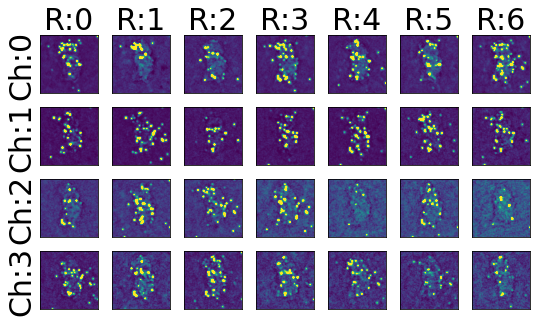

In [4]:
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,:],vmax=10)
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

OPTION 2. We can also visualize the data using animated gifs.  Since this data has a round x channel form, we can use lookup tables (LUTs) to make pretty pictures.  Here we get one image per round, with colors representing activity in different channels.

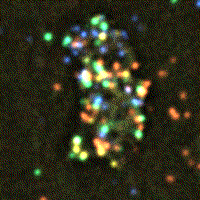

In [5]:
IPython.display.Image(bardensr.plotting.gify(bench.X[:,:,0],normstyle='each'),width=250)

Either way we see pretty clearly that this region of data has a few prominent spots in it.  Let's zero in on just one of them:

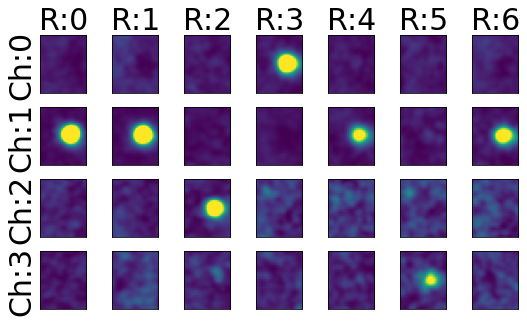

In [6]:
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,25:50,35:55],vmax=10)
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

In [7]:
IPython.display.Image(bardensr.plotting.gify(bench.X[:,:,0,25:50,35:55],normstyle='all'),width=250)

If we want to look at only a *single voxel* we can look at it with a simple heatmap:

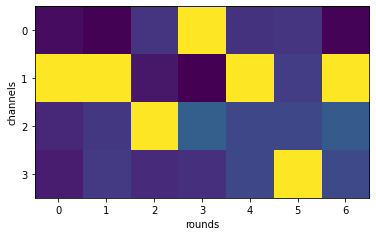

In [8]:
plt.imshow(bench.X[:,:,0,37,47].T,vmax=10)  # look at voxel at (0,37.45)
plt.xlabel("rounds")
plt.ylabel("channels"); plt.yticks(range(4));

At this voxel, we can see that the tissue shows up brightly only in very specific images.  Specifically it shows up in channel 1, then channel 1 again, then channel 2, then channel 0, then channel 3, then channel 1.  This turns out to correspond to the 20th barcode in this experiments' codebook:

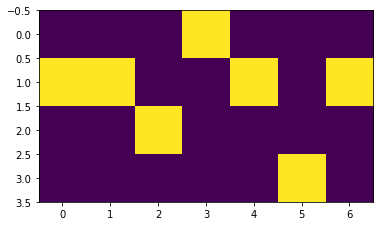

In [9]:
plt.imshow(bench.codebook[:,:,20].T)

In [10]:
# we can identify barcodes quickly using this convenience function:
print("rolonies which show up in channels 1120131 correspond to the following barcodes:",
      bardensr.benchmarks.query_onehot_codebook(bench.codebook,'1120131'))

rolonies which show up in channels 1120131 correspond to the following barcodes: [20]


# Preprocessing

Bardensr generally expects imagestacks in the form (N x M0 x M1 x M2) and codebooks in the form (N x J).  This benchmark has 28 frames (7 rounds and 4 channels).  So we need to convert our data (R x C X M0 x M1 x M2) into this form.

In [11]:
Xflat = bench.X.reshape((28,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
print(Xflat.shape)
print(codeflat.shape)

(28, 1, 200, 200)
(28, 65)


### bgsubtraction

It's also usually a good idea to do some preprocessing to remove background and get everything on a reasonable scale.  The following often works in practice.

In [12]:
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

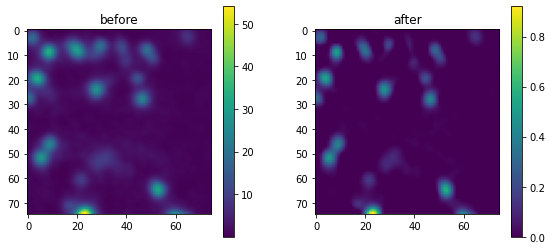

In [13]:
with bardensr.plotting.AnimAcross() as a:
    a('before')
    a.cb(plt.imshow(bench.X[0,0,0][25:100,75:150]))
    
    a('after')
    a.cb(plt.imshow(Xnorm[0,0][25:100,75:150]))

Not much difference.  But just a little preprocessing can go a long way.

###  colorbleed

We have found a type of plot (that we call "colorbleed plots") can help detect if there's colorbleed (or just color-mixing as in original paper) in your data.  We plot 2d histogram of the activity in one channel against the activity in another channel, and then visualize the histogram brightnesses using a log-transformed colormap. 

If there is no colorbleed, between any two frames, we expect to see one of two things.

Option 1.  Two strong streaks along the axes (each streak represents voxels where one frame is bright and the other is silent).

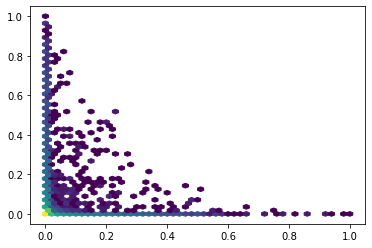

In [14]:
bardensr.preprocessing.colorbleed_plot(Xnorm[0],Xnorm[1])

Option 2.  Three strong streaks (the two aligned streaks from above, together with a streak for voxels where both frames are active).

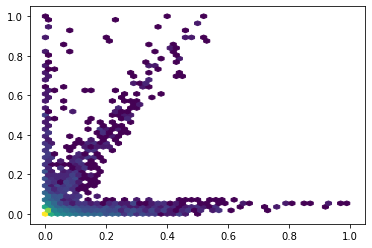

In [15]:
bardensr.preprocessing.colorbleed_plot(Xnorm[0],Xnorm[4])

But in datasets with colorbleed, we see something quite different -- streaks which are just a little bit bent.

Text(0, 0.5, 'Frame 1')

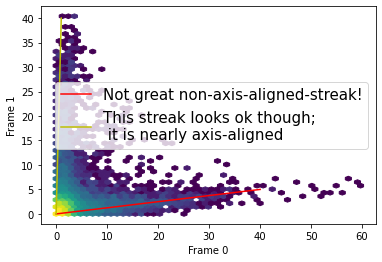

In [16]:
bench_cb=bardensr.load_example('colorbleed_benchmark')
bardensr.preprocessing.colorbleed_plot(bench_cb.X[0,0],bench_cb.X[0,1])
plt.plot([0,40],[0,5],'r-',label='Not great non-axis-aligned-streak!')
plt.plot([0,1],[0,40],'y-',label='This streak looks ok though; \n it is nearly axis-aligned')
plt.legend(fontsize=15)
plt.xlabel("Frame 0")
plt.ylabel('Frame 1')

Above, the bent streak appears because of the following phenomena: **whenever frame 0 is bright, frame 1 is also just a little bit brighter as well**.  This suggests color-bleed (or color-mixing).  If the color-bleed is very bad, this can cause problems for spot-calling.

To correct, we need to find the color-mixing matrix and invert it.  We have some algorithms for doing this  
automatically, but a manual approach is not very difficult.  This is especially true if the data takes a round-by-channel configuration, and we assume there is no colorbleed across rounds.  So we only need to find the colormixing matrix among the 4 colors, i.e. a 4x4 matrix.

Basically we want to make a matrix which is basically the identity, EXCEPT that if we have the phenomena "whenever color `c` is bright, color `d` is also a bit bright" then we have a small positive number in the matrix at row c and column d.

Text(0, 0.5, 'Frame 1')

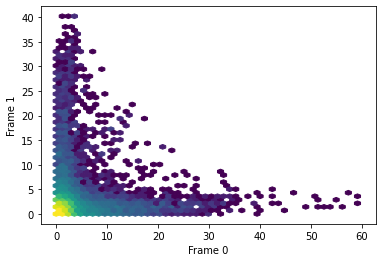

In [17]:
colormixing_matrix=np.array([
    [1,.05,0,0],  # matrix[0,1] is positive because whenever frame 0 is bright, frame 1 is also a bit bright
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1],
])
fix=np.linalg.inv(colormixing_matrix)
fixed_imagestack= np.clip(np.einsum('rcxyz,cd->rdxyz',bench_cb.X,fix),0,None)

bardensr.preprocessing.colorbleed_plot(fixed_imagestack[0,0],fixed_imagestack[0,1])
plt.xlabel("Frame 0")
plt.ylabel('Frame 1')

Above we've only looked at colorbleed between channel 0 and channel 1.  Let's look more generally...

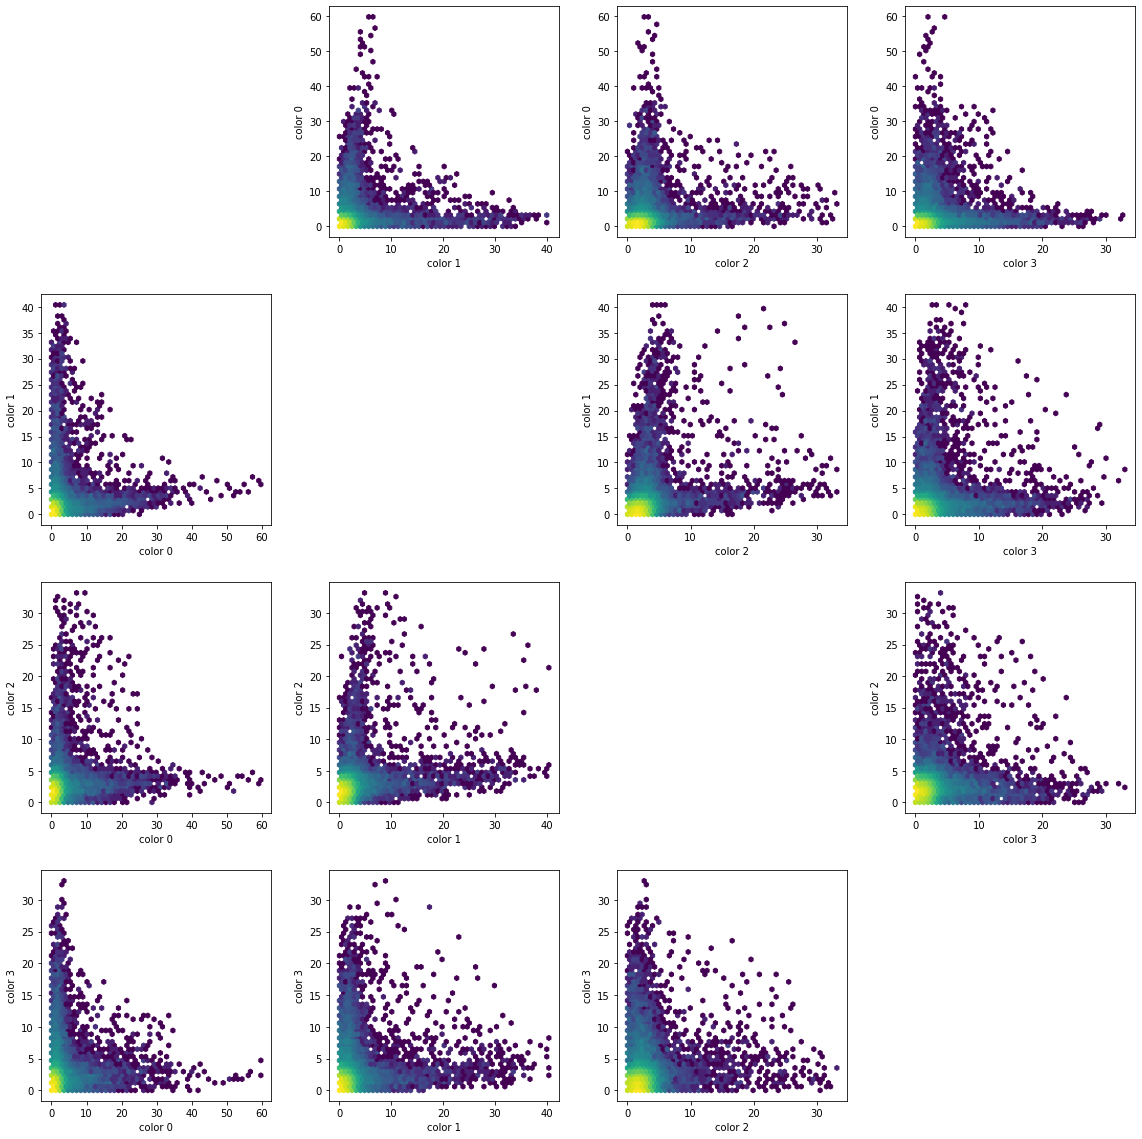

In [18]:
with bardensr.plotting.AnimAcross(columns=4) as a:
    for c in range(4):
        for d in range(4):
            ~a
            if c!=d:
                bardensr.preprocessing.colorbleed_plot(bench_cb.X[0,d],bench_cb.X[0,c])
                plt.xlabel(f'color {d}')
                plt.ylabel(f'color {c}')
            else:
                plt.axis('off')

Pay attention to channel 1 and 2, as well as channel 1, 3. 

In [19]:
# we see some action in 1->3, 1->2, 0->1, and just a little in 0->3 so we put the entries in the matrix
colormixing_matrix=np.array([
    [1,.05,0,.025],   # <-- you can usually figuring out reasonable values by trial and error, .05 is a good place to start
    [0,1,.05,.05],
    [0,0,1,0],
    [0,0,0,1],
])
fix=np.linalg.inv(colormixing_matrix)
fixed_imagestack= np.clip(np.einsum('rcxyz,cd->rdxyz',bench_cb.X,fix),0,None)


Error: Jupyter cannot be started. Error attempting to locate jupyter: Data Science libraries notebook and jupyter are not installed in interpreter Python 3.8.2 64-bit.

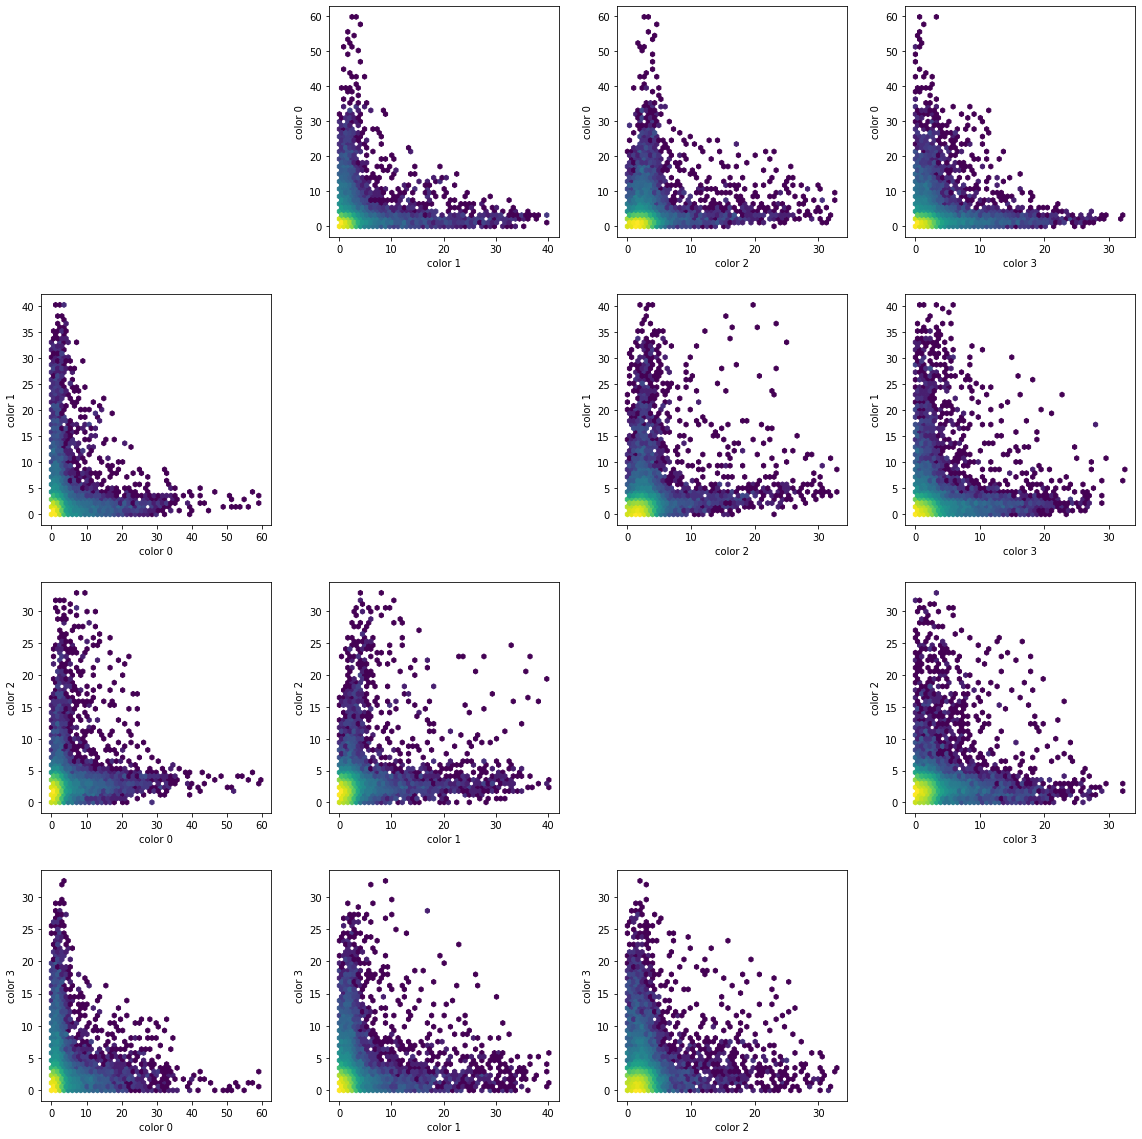

In [20]:
# let's look at the corrected result
with bardensr.plotting.AnimAcross(columns=4) as a:
    for c in range(4):
        for d in range(4):
            ~a
            if c!=d:
                bardensr.preprocessing.colorbleed_plot(fixed_imagestack[0,d],fixed_imagestack[0,c])
                plt.xlabel(f'color {d}')
                plt.ylabel(f'color {c}')
            else:
                plt.axis('off')

Looks good.

# Registration

Some datasets have registration issues.  We have a benchmark which showcases this problem, and how BarDensr can help.

In [21]:
# load benchmark
bench=bardensr.load_example('registration_benchmark')

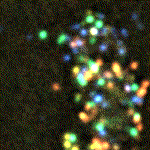

In [22]:
# since the frames of this benchmark have a rounds x 4 representation, we can visualize it with a LUT video
IPython.display.Image(bardensr.plotting.gify(bench.X[:,:,0],normstyle='each'),width=250)

In [23]:
# preprocess
Xflat = bench.X.reshape((28,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [24]:
# correct registration  (the first time you run this it make take a little while; tensorflow has to compile
# the codes)
corrections=bardensr.registration.find_translations_using_model(Xnorm,codeflat,use_tqdm_notebook=True)

  0%|          | 0/50 [00:00<?, ?it/s]

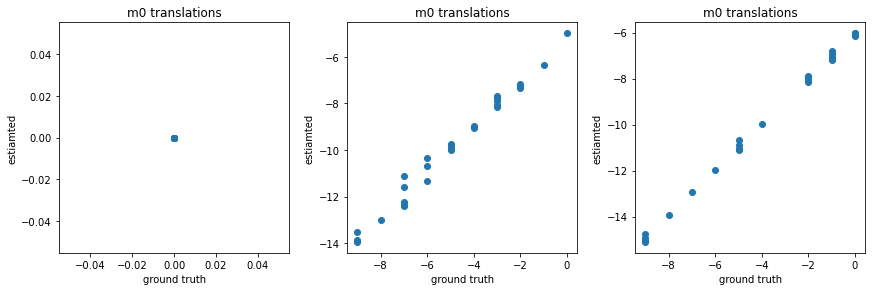

In [25]:
# compare ground-truth translations with learned ones; we do a good job.
# they're off by a constant (but note that we are only trying to estimate 
# the relative translations, so this doesn't matter.
with bardensr.plotting.AnimAcross() as a:
    for i in range(3):
        a(f'm{0} translations')
        plt.scatter(-bench.translations.reshape((28,3))[:,i],corrections[:,i])
        plt.xlabel("ground truth")
        plt.ylabel("estiamted")

In [26]:
# apply translations
Xnorm_registered,newt=bardensr.registration.apply_translations(Xnorm,corrections)

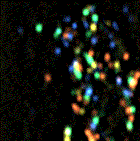

In [27]:
# look at the corrected result
Xnorm_registered_unflat=Xnorm_registered.reshape((7,4,)+Xnorm_registered.shape[1:])
IPython.display.Image(bardensr.plotting.gify(Xnorm_registered_unflat[:,:,0],normstyle='each'),width=250)

Looks good.

# Spot calling (the simple way)

The simplest way to analyze this data is to look at every single voxel and see if it corresponds to one of the barcodes.  We call this the "barcodes first" approach, and have some simple code which implements it at blazing-fast speeds in tensorflow (thereby allowing GPU acceleration if available).  When the data is reasonably sparse, this works great.

First, for every voxel and every barcode we compute the agreement between that voxel and that barcode (as measured by something like a normalized correlation).  We call this the "evidence tensor".

In [28]:
# preprocess
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')
R,C,J=bench.codebook.shape
F=R*C
Xflat = bench.X.reshape((R*C,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)


evidence_tensor=bardensr.spot_calling.estimate_density_singleshot(Xnorm,codeflat,noisefloor=.05)

We can visualize this over many voxels and many barcodes.  Below, for each of several barcodes, we visualize the agreement over a region of voxels:

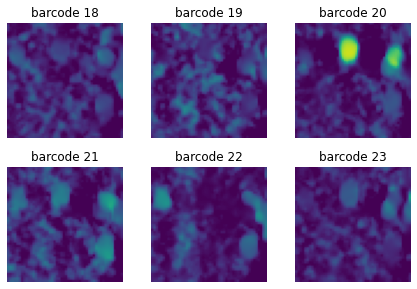

In [29]:
with bardensr.plotting.AnimAcross(sz=2) as a:
    for j in [18,19,20,21,22,23]:
        a(f'barcode {j}')
        plt.imshow(evidence_tensor[0,25:75,25:75,j],vmin=0,vmax=1)
        plt.axis('off')

We can see that in this region of voxels, barcode 20 has very strong agreement in one place.  We can use this agreement as a criteria for deciding whether or not there was a rolony of a given type in each location.  In particular, using a simple peak calling approach we can identify the positions of many of the rolonies in the data.

In [30]:
thresh=.72
result=bardensr.spot_calling.find_peaks(evidence_tensor,thresh)
result

,m0,m1,m2,j
0,0,85,110,1
1,0,87,127,1
2,0,102,142,1
3,0,105,140,1
4,0,114,82,1
...,...,...,...,...
121,0,40,69,50
122,0,45,79,50
123,0,47,71,50
124,0,50,103,50


The result is a pandas dataframe with one row for each rolony.  The first three columns indicate the estimated spatial  position of the rolony, and the last column indicates the barcode that it is assocaited with.

### looking at the accuracy


We can compare this dataframe with the ground-truth.  This ground-truth has been painstakingly constructed, one rolony at a time, and is stored in the benchmark.  To do so we must specify a "radius of wiggle" -- if the benchmark says theres a rolony at once position but our result says there's a rolony just one voxel away, we don't want to count that as a failure.  A radius of 5 voxels is pretty reasonable for this data: 

In [31]:
comparison=bench.rolony_fpfn(result,5)
print("How many false positive?",comparison.fp) # <-- spots that this simple method found that aren't real
print("How many false negatives?",comparison.fn) # <-- spots that this simple method failed to find
print("How many total rolonies detected?",len(result))

How many false positive? 8
How many false negatives? 5
How many total rolonies detected? 126


We can look at the failure modes of this simple method.

**FALSE POSITIVE EXAMPLE**

The simple method thought there was a rolony here with barcode 1


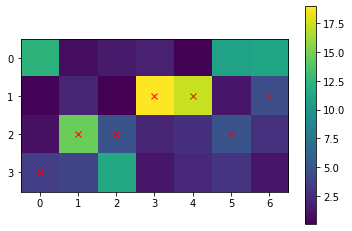

In [32]:
locals().update(dict(comparison.fp_rolonies.iloc[0]))
print("The simple method thought there was a rolony here with barcode",j)
plt.imshow(bench.X[:,:,0,m1,m2].T)
plt.plot(*np.where(bench.codebook[:,:,j]),'rx');
plt.colorbar();

There is *some* signal in all of the relevant places.  But this is probably false positive.  If we look at the area round here we see that this signal is really quite small in absolute terms, and is probably due to spurious signal from nearby rolonies.

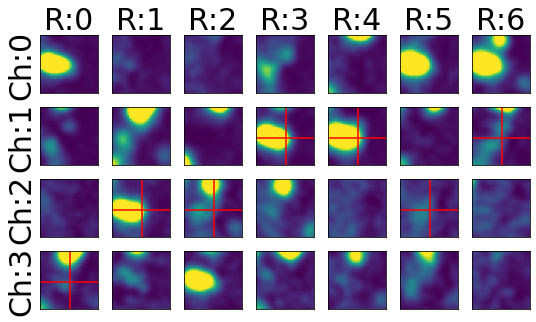

In [33]:
locals().update(dict(comparison.fp_rolonies.iloc[0]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmax=15)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

**FALSE NEGATIVE EXAMPLE**

There's a rolony here with barcode 13 but this simple method failed to find it.


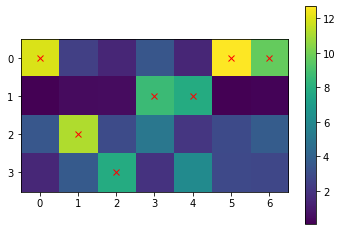

In [34]:
locals().update(dict(comparison.fn_rolonies.iloc[0]))
print("There's a rolony here with barcode",j,"but this simple method failed to find it.")
plt.imshow(bench.X[:,:,0,m1,m2].T)
plt.plot(*np.where(bench.codebook[:,:,j]),'rx');
plt.colorbar()

Its easy to see why the simple method failed to identify this spot -- there are actually TWO rolonies here, in the same place!  This confuses the simple method.

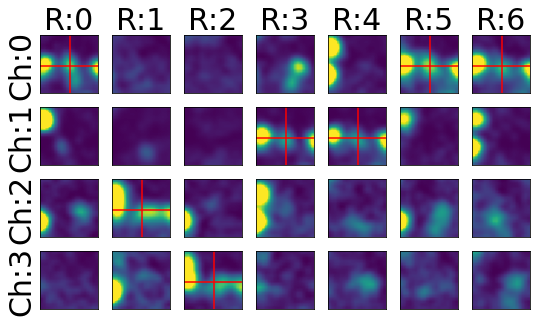

In [35]:

locals().update(dict(comparison.fn_rolonies.iloc[0]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmax=15)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

# Spot-calling (the iterative way)

Another way to analyze the data is to use an optimization approach to directly invert our observation model.  In some ways this is similar to the way proposed above -- for each voxel and each barcode we identify a nonnegative density indicating how much that barcode is present at that location.  Then we can identify peaks in these densities to find rolonies.

In [36]:
# preprocess
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')
R,C,J=bench.codebook.shape
F=R*C
Xflat = bench.X.reshape((R*C,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [37]:
evidence_tensor_iterative,extra_learned_params=\
    bardensr.spot_calling.estimate_density_iterative(Xnorm,codeflat,use_tqdm_notebook=True,iterations=100)

  0%|          | 0/100 [00:00<?, ?it/s]

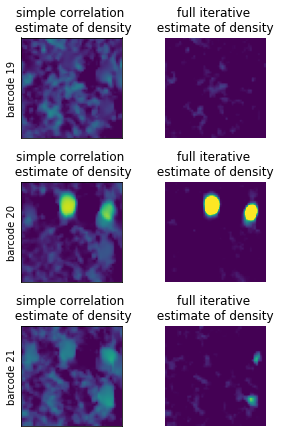

In [38]:
with bardensr.plotting.AnimAcross(sz=2,columns=2,ratio=.7) as a:
    for j in [19,20,21]:
        a(f'simple correlation \n estimate of density')
        plt.imshow(evidence_tensor[0,25:75,25:75,j],vmin=0,vmax=1)
        plt.ylabel(f'barcode {j}')
        plt.xticks([]); plt.yticks([])
        
        a('full iterative \n estimate of density ')
        plt.imshow(evidence_tensor_iterative[0,25:75,25:75,j],vmin=0,vmax=.5)
        plt.axis('off')

Note that the BarDensr answers are much less noisy!  It also calculates some interpretable parameters, such as a gain parameter for each of the frames:

Text(0, 0.5, 'channels')

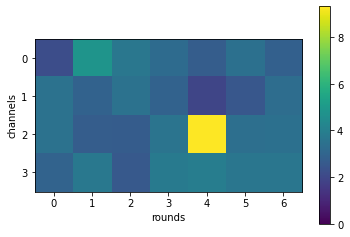

In [39]:
plt.imshow(extra_learned_params['frame_gains'].reshape((7,4)).T,vmin=0)
plt.colorbar()
plt.xlabel("rounds")
plt.ylabel('channels')

For this dataset, the accuracy is not that different from the simple method though:

In [40]:
thresh_iterative=evidence_tensor_iterative.max()*.1
result_iterative=bardensr.spot_calling.find_peaks(evidence_tensor_iterative,thresh_iterative)
comparison_bardensr=bench.rolony_fpfn(result_iterative,5)
print("How many false positive?",comparison_bardensr.fp) 
print("How many false negatives?",comparison_bardensr.fn)
print("How many total rolonies detected?",len(result_iterative))

How many false positive? 15
How many false negatives? 5
How many total rolonies detected? 131


Dim spots are hard.  Here's a very dim false negative.

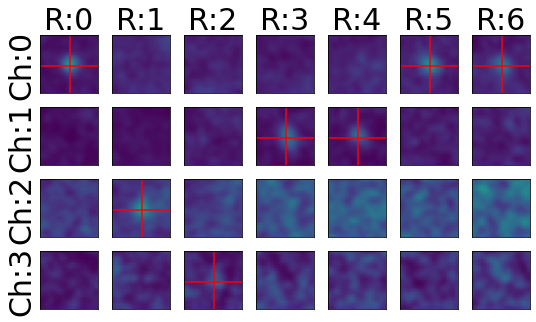

In [41]:
locals().update(dict(comparison_bardensr.fn_rolonies.iloc[1]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmin=0,vmax=10)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

We can see that BarDensr suspects there is some signal there, but it just isn't above the threshold:

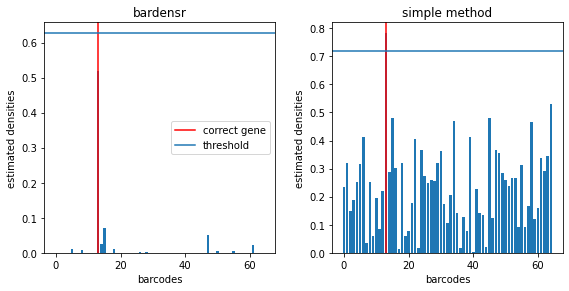

In [42]:
with bardensr.plotting.AnimAcross() as a:
    locals().update(dict(comparison_bardensr.fn_rolonies.iloc[1]))
    
    a('BarDensr')
    plt.bar(range(bench.n_genes),evidence_tensor_iterative[0,m1,m2])
    plt.axvline(j,color='red',label='correct gene')
    plt.axhline(thresh_iterative,color='C0',label='threshold')
    plt.legend()
    plt.ylabel('estimated densities')
    plt.xlabel('barcodes')
    plt.legend()
    
    a('simple method')
    plt.bar(range(bench.n_genes),evidence_tensor[0,m1,m2])
    plt.axvline(j,color='red',label='correct gene')
    plt.axhline(thresh,color='C0')
    plt.ylabel('estimated densities')
    plt.xlabel('barcodes')

Here's a case where BarDensr thinks there is something there -- but really there's not...

bardensr thinks barcode 3 is here, i.e. [1 3 3 1 0 3 1] -- but it is wrong


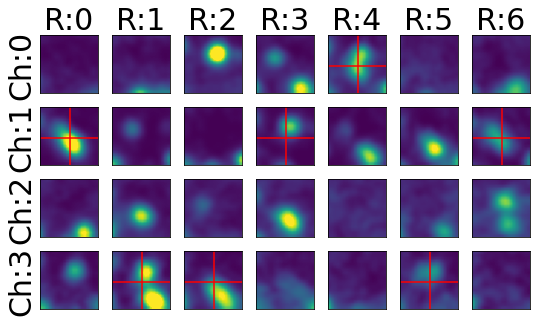

In [43]:
locals().update(dict(comparison_bardensr.fp_rolonies.iloc[1]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmin=0,vmax=30)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

print('bardensr thinks barcode',j,'is here, i.e.',np.where(bench.codebook[:,:,j])[1],'-- but it is wrong')

It is easy to see why BarDensr would get confused.  There is indeed some signal in all the images associated with this barcode.  However, this collection of images is actually better explained as a combination of barcodes 18 and 1.  The signal in the later rounds of channel 0 is very likely spurious.